# Combining Python, SQL DBs and AWS

## Aim: Create a RDB instance on AWS, connect to it through python, and execute queries.  


## Create an instance on AWS  
    
https://aws.amazon.com/getting-started/tutorials/create-mysql-db/

##  Using MYSQLWorkbench

Before we complicate things with using Python, we want to use MYSQLWorkbench to make sure we set up our AWS server correctly and can connect to it.  

- Create a connection to the AWS server
- Execute a simple create table query
- Drop the table


# Using Python with MYSQL DB

In [3]:
# make sure we have the package installed
!pip install mysql-connector-python

  Using cached https://files.pythonhosted.org/packages/b0/d6/19f81615060d9a0eae204bd621fb5aa6604abc3fa45123583df029bd0895/mysql_connector_python-8.0.18-cp37-cp37m-macosx_10_13_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/63/c3/c1929b176a62f2960fe8f9346bd7c3ed42dc2af7d61c0e9b21e36c68e2ce/protobuf-3.11.1-cp37-cp37m-macosx_10_9_intel.whl


In [156]:
## importing 'mysql.connector' 
import mysql.connector 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [6]:
## Connecting to the database

## connecting to the database using 'connect()' method
## it takes 3 required parameters 'host', 'user', 'passwd'
cnx = mysql.connector .connect(
    host = "localhost",
    user = "root",
    passwd = "dbms"
)

DatabaseError: 2003 (HY000): Can't connect to MySQL server on 'localhost' (61)

### Documentation:

https://dev.mysql.com/doc/connector-python/en/connector-python-connectargs.html

## Using a config File:

You do not want to make your credentials viewable to everyone who might see this file.  So instead of explicity stating your credentials, we want to import them from another file.  

In [157]:
import config
import datetime

In [158]:
config.password

'Emma815acc'

In [159]:
## Connecting to the database

## connecting to the database using 'connect()' method
## it takes 3 required parameters 'host', 'user', 'passwd'
cnx = mysql.connector .connect(
    host = config.host,
    user = config.user,
    passwd = config.password
)

print(cnx) # it will print a connection object if everything is fine


In [160]:
cursor = cnx.cursor()

## Creating DB

In [161]:
import mysql.connector
from mysql.connector import errorcode

In [162]:
db_name = 'employees'

In [163]:
def create_database(cursor, database):
    try:
        cursor.execute(
            "CREATE DATABASE {} DEFAULT CHARACTER SET 'utf8'".format(database))
    except mysql.connector.Error as err:
        print("Failed creating database: {}".format(err))
        exit(1)

try:
    cursor.execute("USE {}".format(db_name))
except mysql.connector.Error as err:
    print("Database {} does not exists.".format(db_name))
    if err.errno == errorcode.ER_BAD_DB_ERROR:
        create_database(cursor, db_name)
        print("Database {} created successfully.".format(db_name))
        cnx.database = db_name
    else:
        print(err)
        exit(1)

### Creating tables

In [164]:
DB_NAME = 'employees'

TABLES = {}
TABLES['employees'] = (
    "CREATE TABLE employees ("
    "  emp_no int(11) NOT NULL AUTO_INCREMENT,"
    "  birth_date date NOT NULL,"
    "  first_name varchar(14) NOT NULL,"
    "  last_name varchar(16) NOT NULL,"
    "  gender enum('M','F') NOT NULL,"
    "  hire_date date NOT NULL,"
    "  PRIMARY KEY (emp_no)"
    ") ENGINE=InnoDB")

TABLES['departments'] = (
    "CREATE TABLE departments ("
    "  dept_no char(4) NOT NULL,"
    "  dept_name varchar(40) NOT NULL,"
    "  PRIMARY KEY (dept_no), UNIQUE KEY dept_name (dept_name)"
    ") ENGINE=InnoDB")

TABLES['salaries'] = (
    "CREATE TABLE salaries ("
    "  emp_no int(11) NOT NULL,"
    "  salary int(11) NOT NULL,"
    "  from_date date NOT NULL,"
    "  to_date date NOT NULL,"
    "  PRIMARY KEY (emp_no,from_date), KEY emp_no (emp_no),"
    "  CONSTRAINT salaries_ibfk_1 FOREIGN KEY (emp_no) "
    "     REFERENCES employees (emp_no) ON DELETE CASCADE"
    ") ENGINE=InnoDB")

TABLES['dept_emp'] = (
    "CREATE TABLE dept_emp ("
    "  emp_no int(11) NOT NULL,"
    "  dept_no char(4) NOT NULL,"
    "  from_date date NOT NULL,"
    "  to_date date NOT NULL,"
    "  PRIMARY KEY (emp_no,dept_no), KEY emp_no (emp_no),"
    "  KEY dept_no (dept_no),"
    "  CONSTRAINT dept_emp_ibfk_1 FOREIGN KEY (emp_no) "
    "     REFERENCES employees (emp_no) ON DELETE CASCADE,"
    "  CONSTRAINT dept_emp_ibfk_2 FOREIGN KEY (dept_no) "
    "     REFERENCES departments (dept_no) ON DELETE CASCADE"
    ") ENGINE=InnoDB")

TABLES['dept_manager'] = (
    "  CREATE TABLE dept_manager ("
    "  dept_no char(4) NOT NULL,"
    "  emp_no int(11) NOT NULL,"
    "  from_date date NOT NULL,"
    "  to_date date NOT NULL,"
    "  PRIMARY KEY (emp_no,dept_no),"
    "  KEY emp_no (emp_no),"
    "  KEY dept_no (dept_no),"
    "  CONSTRAINT dept_manager_ibfk_1 FOREIGN KEY (emp_no) "
    "     REFERENCES employees (emp_no) ON DELETE CASCADE,"
    "  CONSTRAINT dept_manager_ibfk_2 FOREIGN KEY (dept_no) "
    "     REFERENCES departments (dept_no) ON DELETE CASCADE"
    ") ENGINE=InnoDB")

TABLES['titles'] = (
    "CREATE TABLE titles ("
    "  emp_no int(11) NOT NULL,"
    "  title varchar(50) NOT NULL,"
    "  from_date date NOT NULL,"
    "  to_date date DEFAULT NULL,"
    "  PRIMARY KEY (emp_no,title,from_date), KEY emp_no (emp_no),"
    "  CONSTRAINT titles_ibfk_1 FOREIGN KEY (emp_no)"
    "     REFERENCES employees (emp_no) ON DELETE CASCADE"
    ") ENGINE=InnoDB")

In [165]:
TABLES['employees']

"CREATE TABLE employees (  emp_no int(11) NOT NULL AUTO_INCREMENT,  birth_date date NOT NULL,  first_name varchar(14) NOT NULL,  last_name varchar(16) NOT NULL,  gender enum('M','F') NOT NULL,  hire_date date NOT NULL,  PRIMARY KEY (emp_no)) ENGINE=InnoDB"

In [166]:
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.password,
    database = 'employees'
)
cursor = cnx.cursor()

In [167]:
for table_name in TABLES:
    table_description = TABLES[table_name]
    try:
        print("Creating table {}: ".format(table_name), end='')
        cursor.execute(table_description)
    except mysql.connector.Error as err:
        if err.errno == errorcode.ER_TABLE_EXISTS_ERROR:
            print("already exists.")
        else:
            print(err.msg)
    else:
        print("OK")

cursor.close()
cnx.close()

Creating table employees: already exists.
Creating table departments: already exists.
Creating table salaries: already exists.
Creating table dept_emp: already exists.
Creating table dept_manager: already exists.
Creating table titles: already exists.


## Inserting Data

In [168]:
from datetime import date, datetime, timedelta

#since we closed the connection, we need to reinstatiate it
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.password,
    database = 'employees'
)
cursor = cnx.cursor()

tomorrow = datetime.now().date() + timedelta(days=1)

add_employee = ("INSERT INTO employees "
               "(first_name, last_name, hire_date, gender, birth_date) "
               "VALUES (%s, %s, %s, %s, %s)")
add_salary = ("INSERT INTO salaries "
              "(emp_no, salary, from_date, to_date) "
              "VALUES (%(emp_no)s, %(salary)s, %(from_date)s, %(to_date)s)")

data_employee = ('Geert', 'Vanderkelen', tomorrow, 'M', date(1977, 6, 14))



In [169]:
# Insert new employee
cursor.execute(add_employee, data_employee)
emp_no = cursor.lastrowid

# Insert salary information
data_salary = {
  'emp_no': emp_no,
  'salary': 50000,
  'from_date': tomorrow,
  'to_date': date(9999, 1, 1),
}
cursor.execute(add_salary, data_salary)

# Make sure data is committed to the database
cnx.commit()

cursor.close()
cnx.close()

## Insert Many

cursor.executemany(operation, seq_of_params)

In [170]:
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.password,
    database = DB_NAME
)
cursor = cnx.cursor()

In [155]:
data = [
  ('Jane', date(2005, 2, 12)),
  ('Joe', date(2006, 5, 23)),
  ('John', date(2010, 10, 3)),
]
stmt = "INSERT INTO employees (first_name, hire_date) VALUES (%s, %s)"
cursor.executemany(stmt, data)

ProgrammingError: 1146 (42S02): Table 'production.employees' doesn't exist

## Quyerying the DB

In [18]:
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.password,
    database = DB_NAME
)
cursor = cnx.cursor()

In [19]:
query = "SELECT * FROM employees; "



In [20]:
cursor.execute(query)

In [21]:
result = cursor.fetchall()

In [22]:
for l in result:
    print (l)

(1, datetime.date(1977, 6, 14), 'Geert', 'Vanderkelen', 'M', datetime.date(2019, 12, 4))
(2, None, 'Jane', '', 'M', datetime.date(2005, 2, 12))
(3, None, 'Joe', '', 'M', datetime.date(2006, 5, 23))
(4, None, 'John', '', 'M', datetime.date(2010, 10, 3))
(5, datetime.date(1977, 6, 14), 'Geert', 'Vanderkelen', 'M', datetime.date(2019, 12, 4))
(6, datetime.date(1977, 6, 14), 'Geert', 'Vanderkelen', 'M', datetime.date(2019, 12, 5))


In [23]:

query = ("SELECT first_name, last_name, hire_date FROM employees "
         "WHERE hire_date BETWEEN %s AND %s")

hire_start = datetime.date(1999, 1, 1)
hire_end = datetime.date(1999, 12, 31)

cursor.execute(query, (hire_start, hire_end))

for (first_name, last_name, hire_date) in cursor:
  print("{}, {} was hired on {:%d %b %Y}".format(
    last_name, first_name, hire_date))

cursor.close()
cnx.close()

TypeError: descriptor 'date' requires a 'datetime.datetime' object but received a 'int'

In [129]:
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.password,
    database = 'production'
)
cursor = cnx.cursor()

In [130]:
q1 = ('''
SELECT
    p.product_name,
    p.list_price,
    p.brand_id,
    b.brand_name
FROM
    production.products p
LEFT JOIN
    production.brands b
ON
    p.brand_id = b.brand_id
''')

In [124]:
cursor.execute(q1)

r1 = cursor.fetchall()

for i in r1:
    print(i)

('Trek 820 - 2016', Decimal('379.99'), 9, 'Trek')
('Ritchey Timberwolf Frameset - 2016', Decimal('749.99'), 5, 'Ritchey')
('Surly Wednesday Frameset - 2016', Decimal('999.99'), 8, 'Surly')
('Trek Fuel EX 8 29 - 2016', Decimal('2899.99'), 9, 'Trek')
('Heller Shagamaw Frame - 2016', Decimal('1320.99'), 3, 'Heller')
('Surly Ice Cream Truck Frameset - 2016', Decimal('469.99'), 8, 'Surly')
('Trek Slash 8 27.5 - 2016', Decimal('3999.99'), 9, 'Trek')
('Trek Remedy 29 Carbon Frameset - 2016', Decimal('1799.99'), 9, 'Trek')
('Trek Conduit+ - 2016', Decimal('2999.99'), 9, 'Trek')
('Surly Straggler - 2016', Decimal('1549.00'), 8, 'Surly')
('Surly Straggler 650b - 2016', Decimal('1680.99'), 8, 'Surly')
('Electra Townie Original 21D - 2016', Decimal('549.99'), 1, 'Electra')
('Electra Cruiser 1 (24-Inch) - 2016', Decimal('269.99'), 1, 'Electra')
("Electra Girl's Hawaii 1 (16-inch) - 2015/2016", Decimal('269.99'), 1, 'Electra')
('Electra Moto 1 - 2016', Decimal('529.99'), 1, 'Electra')
('Electra Town

In [114]:
type(r1)

list

In [115]:
len(r1)

321

In [116]:
df = pd.DataFrame(r1) 
df.columns = [x[0] for x in cursor.description]
df.head(2)

,product_name,list_price,brand_id,brand_name
0,Trek 820 - 2016,379.99,9,Trek
1,Ritchey Timberwolf Frameset - 2016,749.99,5,Ritchey


<Figure size 720x720 with 0 Axes>

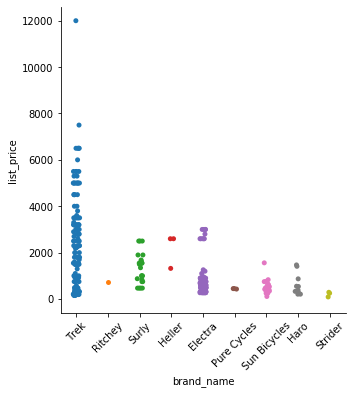

In [117]:
plt.figure(figsize=(10,10))
g = sns.catplot(x='brand_name', y='list_price', data=df)
g.set_xticklabels(rotation=45)

In [118]:
q2 = '''
SELECT
    p.model_year
FROM
    production.products p
    ;
'''

In [132]:
cursor.execute(q2)

r2 = cursor.fetchall()


df = pd.DataFrame(r2) 
df.columns = [x[0] for x in cursor.description]
df



,model_year
0,2016
1,2016
2,2016
3,2016
4,2016
...,...
316,2019
317,2019
318,2019
319,2019


In [145]:
def make_df(query):
    cursor.execute(query)
    result = cursor.fetchall() 
    namedf = 'df_'+ retrieve_name(query) 
    exec("%s = %d" % (namedf, pd.DataFrame(result))) 
    namedf.columns = [x[0] for x in cursor.description]
    return(retrieve_name(namedf))
    

In [107]:
import inspect


def retrieve_name(var):
        """
        Gets the name of var. Does it from the out most frame inner-wards.
        :param var: variable to get name from.
        :return: string
        """
        for fi in reversed(inspect.stack()):
            names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
            if len(names) > 0:
                return names[0]

In [146]:
make_df(q1)

TypeError: %d format: a number is required, not DataFrame

NameError: name 'df_q1' is not defined

In [153]:
my_dict = {}
x = "x1"
my_dict[x] = pd.DataFrame(r2) 

In [154]:
my_dict['x1']

,0
0,2016
1,2016
2,2016
3,2016
4,2016
...,...
316,2019
317,2019
318,2019
319,2019
